In [250]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

# 2. Разделение датасета и препроцесинг
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# 3. Модели
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb



# 4. Метрики качества
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, auc, roc_auc_score, roc_curve
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import contingency_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Предобработка и Визуализация данных

### Цель - Прогнозирование выполнения долговых обязательств по кредиту
Целевая переменая -  
* Credit Default - просрочка по кредиту 1 - просрочка есть 0 - просрочки нет
Признаки - 
* Annual Income - гоовой доход
* Tax Liens - налоговые
* Number of Open Accounts - количество открытвых банковских счетов
* Years of Credit History - количество лет в кредитной истории
* Maximum Open Credit -  максимальная открытая сумма кредита
* Number of Credit Problems - Количество проблем с кредитом
* Bankruptcies - Количество банкротство
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - Текущий кредитный баланс
* Monthly Debt - сумма ежемесечного долго
* Credit Score - Кредитный рейтинг
* Home Ownership - тип владения недвижимостью
* Years in current job - количество лет на текущем месте работы
* Purpose - цель кредита
* Term - срок кредита (краткосрочный или на долгий срок)

#### Целевая метрика - f1 score > 0.5 для класса 1 (просрочка по кредиту)  

In [251]:
PREPARED_DATASET_PATH = '/prepared.csv'
TEST = r'course_project_test.csv'
TRAIN = r'course_project_train.csv'
df = pd.read_csv(TRAIN, sep=',')

In [252]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [253]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Оптимизация памяти

In [254]:
def reduce_mem_usage(df):
    """ проходим по всем колонкам дата фрейма и оптимезируем тип данных в соответствии с диапазоном данных.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

reduce_mem_usage(df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.500000,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.099998,1778920.0,0.0,NaN,0.0,buy a car,Short Term,100000000.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.500000,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [255]:
cat_columns = ['Tax Liens',
       'Number of Credit Problems', 'Bankruptcies',
       'Home Ownership', 'Years in current job', 'Purpose', 'Term']

num_columns = ['Annual Income', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']
tot_columns = cat_columns + num_columns

### Таблица распределения числовых признаков

In [256]:
df[cat_columns] = df[cat_columns].astype('category')
df[num_columns].describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7.500000e+03,3419.000000,7500.0,7.500000e+03,7500.000000,5943.000000
mean,1.366390e+06,11.130934,18.317446,9.451526e+05,34.692600,11873135.0,2.898332e+05,18314.453125,1151.087524
std,8.453384e+05,4.908937,7.041938,1.602614e+07,21.688801,31926302.0,3.178713e+05,11926.758789,1604.447510
min,1.645970e+05,2.000000,4.000000,0.000000e+00,0.000000,11242.0,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,8.000000,13.500000,2.792295e+05,16.000000,180169.0,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,10.000000,17.000000,4.781590e+05,32.000000,309573.0,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,14.000000,21.799999,7.935015e+05,50.000000,519882.0,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,43.000000,57.700001,1.304726e+09,118.000000,100000000.0,6.506797e+06,136679.000000,7510.000000


Визуально видим явные вбросы в признаке Credit Score начение 7510 явно дальше от медианы чем мин значение 585.
В признаке Current Loan Amount так же среднее сильно сдвинуто относительно медианы.

### Провекрка наличия Дубликатов

In [257]:
print(f'Количество дублей {df[df.duplicated()].shape[0]} в нашем сете из {df.shape[0]}')
df.drop_duplicates(keep='first',inplace=True) # оставяем первый вариант
print(f'После удаления количество записей в наборе данных - {df.shape[0]}')

Количество дублей 0 в нашем сете из 7500
После удаления количество записей в наборе данных - 7500


### Работа с пропусками

In [258]:
print(f'Процент пропусков в признаках\n{round(df.isnull().sum()*100/df.shape[0],2)}')

Процент пропусков в признаках
Home Ownership                   0.00
Annual Income                   20.76
Years in current job             4.95
Tax Liens                        0.00
Number of Open Accounts          0.00
Years of Credit History          0.00
Maximum Open Credit              0.00
Number of Credit Problems        0.00
Months since last delinquent    54.41
Bankruptcies                     0.19
Purpose                          0.00
Term                             0.00
Current Loan Amount              0.00
Current Credit Balance           0.00
Monthly Debt                     0.00
Credit Score                    20.76
Credit Default                   0.00
dtype: float64


Процент пропусков в признаке Months since last delinquent - 54.41 слишком велик, отбросим признак

In [259]:
df.drop(columns=['Months since last delinquent'], inplace=True)

In [260]:
def nan_replace(df, target):
    """ Функция для замены данных при бинарной класификации. Заменяет данные в задоном класе медианой или модой 
    пока опробована только на бинарной класификации"""
    
    #1 часть замена числовых признаков
    df_list_num = [] # список для сохранения измененых датафреймы 
    num =  df.select_dtypes(exclude=['category', 'object'])
    for i in num[target].unique():# проходимся по всем значениям класов целевой переменой
        df_loc = num[num[target]==i]
        for col in df_loc: #расматриваем каждый признак в определенном класе
            if df_loc[col].isnull().sum() > 0.0: # работаем с признакми где есть пропуски
                median = df_loc[col].median()
                df_loc.fillna({col:median}, inplace=True)
                print('Класс - ', i, col, 'медиана -', median)
        df_list_num.append(df_loc)
    df_num = pd.concat(df_list_num)
    df_num.drop(columns=[target],inplace=True)

    #2 часть замена категориальных признаков  
    df_list_cat = []
    cat =  df.select_dtypes(include=['category', 'object'])
    cat['Credit Default'] = df['Credit Default']
    for i in cat[target].unique():# проходимся по всем значениям класов целевой переменой
        df_loc = cat[cat[target]==i]
        for col in df_loc: #расматриваем каждый признак в определенном класе
            if df_loc[col].isnull().sum() > 0.0: # работаем с признакми где есть пропуски
                mode = df_loc[col].mode()[0]
                df_loc.fillna({col:mode}, inplace=True)
                print('Класс - ', i, col, 'мода -', mode)
        df_list_cat.append(df_loc)
    df_cat = pd.concat(df_list_cat)
    
    #3 часть обьединение категориальных и числовых признаков
    df=pd.concat([df_num, df_cat], axis=1)
    result = df.isnull().sum()*100/df.shape[0]
    return df


df = nan_replace(df,'Credit Default')
df

Класс -  0 Annual Income медиана - 1225747.0
Класс -  0 Credit Score медиана - 732.0
Класс -  1 Annual Income медиана - 1055915.5
Класс -  1 Credit Score медиана - 730.5
Класс -  0 Years in current job мода - 10+ years
Класс -  0 Bankruptcies мода - 0.0
Класс -  1 Years in current job мода - 10+ years
Класс -  1 Bankruptcies мода - 0.0


,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership,Years in current job,Tax Liens,Number of Credit Problems,Bankruptcies,Purpose,Term,Credit Default
0,482087.0,11.0,26.299999,685960.0,100000000.0,47386.0,7914.0,749.0,Own Home,10+ years,0.0,1.0,1.0,debt consolidation,Short Term,0
2,751412.0,11.0,35.000000,1182434.0,100000000.0,308389.0,13651.0,742.0,Home Mortgage,8 years,0.0,0.0,0.0,debt consolidation,Short Term,0
3,805068.0,8.0,22.500000,147400.0,121396.0,95855.0,11338.0,694.0,Own Home,6 years,0.0,1.0,1.0,debt consolidation,Short Term,0
4,776264.0,13.0,13.600000,385836.0,125840.0,93309.0,7180.0,719.0,Rent,8 years,0.0,1.0,0.0,debt consolidation,Short Term,0
6,1511108.0,9.0,20.299999,388124.0,100000000.0,51623.0,2317.0,745.0,Home Mortgage,10+ years,0.0,0.0,0.0,home improvements,Short Term,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,1542952.0,7.0,12.500000,232364.0,267982.0,198873.0,15430.0,695.0,Home Mortgage,10+ years,0.0,0.0,0.0,debt consolidation,Long Term,1
7489,1394942.0,15.0,27.200001,1441396.0,753764.0,496698.0,16972.0,742.0,Home Mortgage,10+ years,0.0,0.0,0.0,debt consolidation,Short Term,1
7490,1368000.0,20.0,26.700001,897842.0,683650.0,517199.0,29868.0,688.0,Own Home,10+ years,0.0,0.0,0.0,debt consolidation,Short Term,1
7493,1257610.0,14.0,16.500000,821480.0,448052.0,167428.0,27562.0,676.0,Rent,8 years,0.0,0.0,0.0,debt consolidation,Long Term,1


### Визуализация целевой переменой

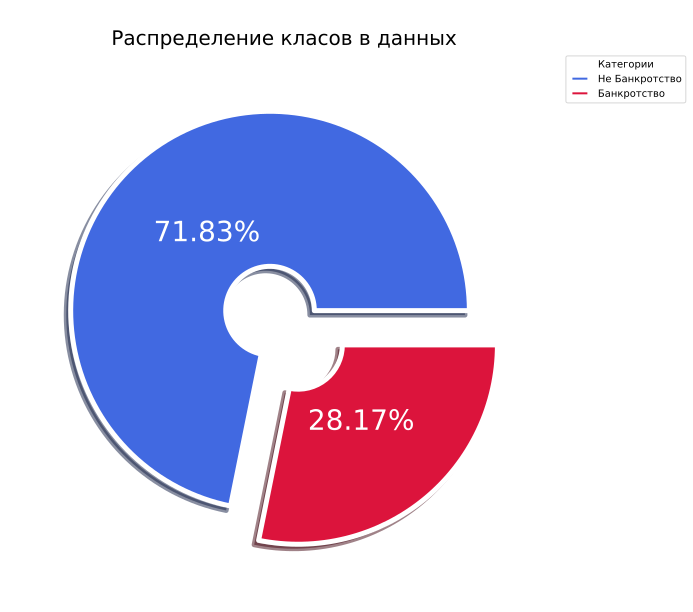

In [261]:
plt.subplots(figsize=(10, 10))

labels = "Не Банкротство","Банкротство"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df[df["Credit Default"]==0]),
                                    len(df[df["Credit Default"]==1])],
                                    colors= ['royalblue', 'crimson'],
                                    explode = (0.1,0.1),
                                    textprops=dict(size= 28, color= "white"), # размер и цвет текста внутри диаграмы
                                    autopct="%.2f%%",
                                    pctdistance = 0.5, # положение текста значение процентов
                                    radius=0.9, 
                                    shadow = True, # добовляет эфект тени к диаграме
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5), # круг добовляет в центре
                                    startangle = 0)

plt.legend(wedges, labels, title="Категории",loc="upper left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nРаспределение класов в данных",fontsize=20)
plt.show();

### Распределения числовых признаков

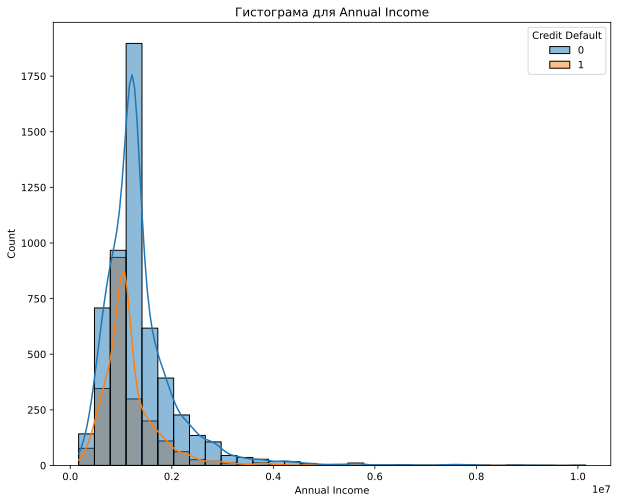

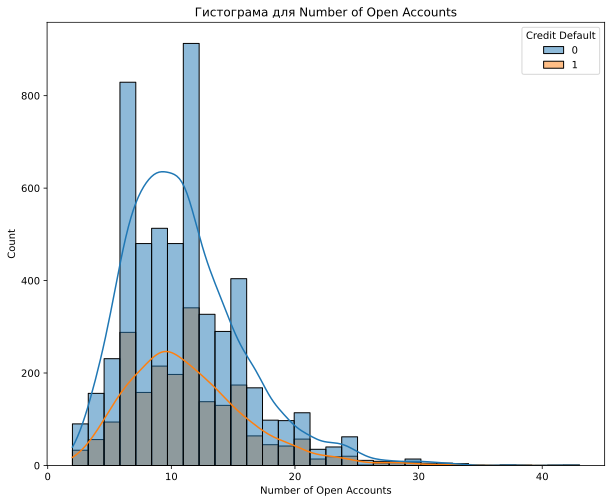

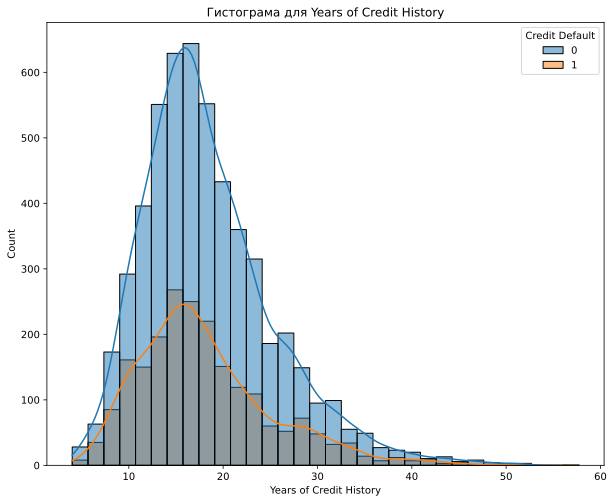

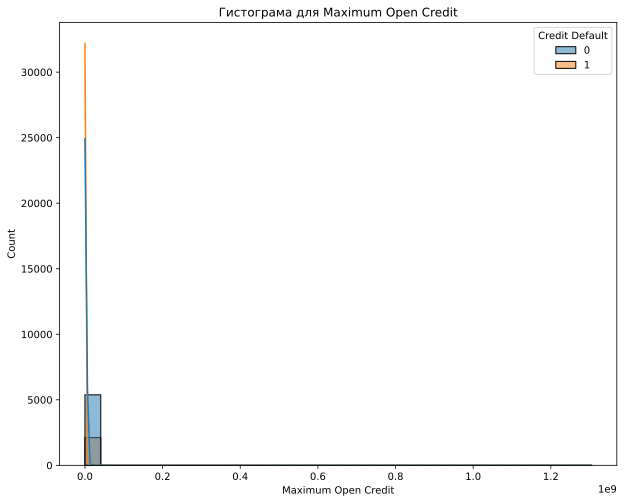

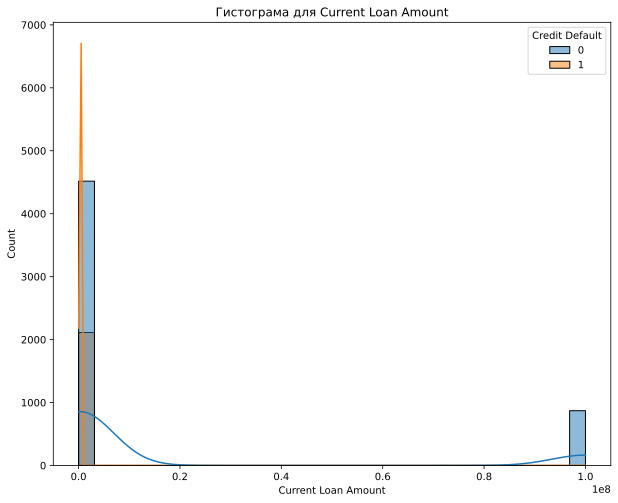

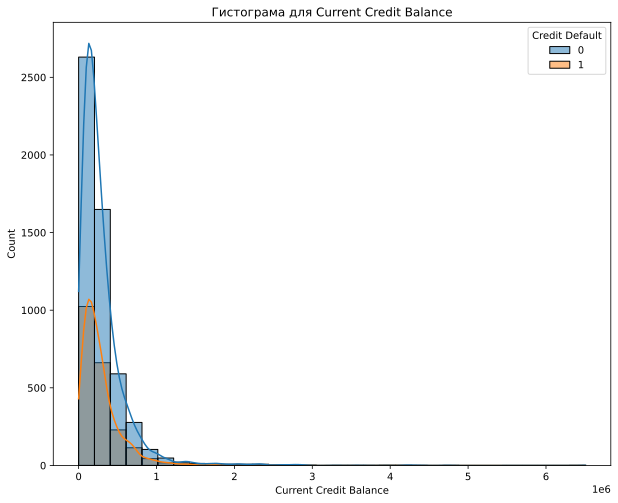

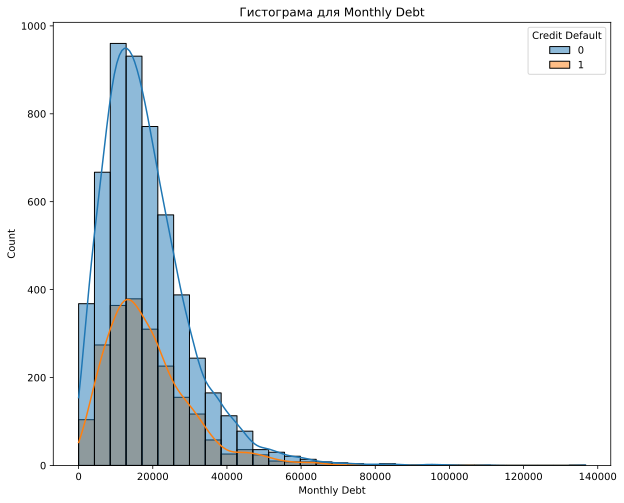

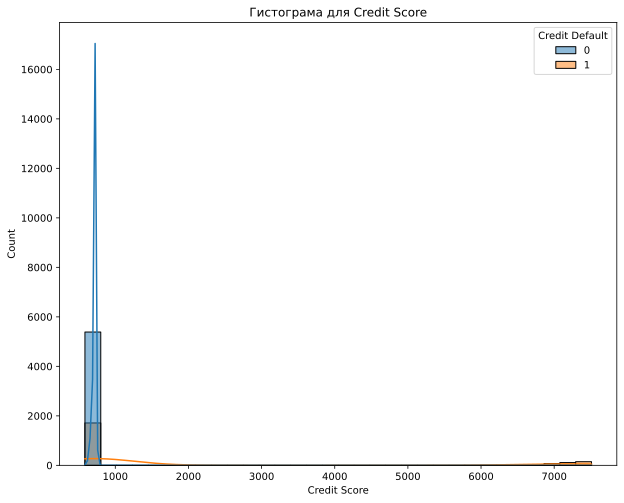

In [263]:
def num_hist(df):
    df_num = df.select_dtypes(exclude=['category', 'object'])
    for col in df_num.columns[:-1]:
        plt.figure(figsize=(10, 8))
        sns.histplot(data=df_num, x=df_num[col], bins=32, kde=True, hue=df_num['Credit Default'])
        plt.title("Гистограма для " + str(col))
num_hist(df)

Признаки ниже подозрительны на наличие явных вбросов и некоректно заполненых данных - 
* Monthly Debt  
* Annual Income
* Maximum Open Credit 
* Current Loan Amount 
* Credit Score 
* Current Credit Balance

### Monthly Debt  и Annual Income

Monthly Debt  и Annual Income имеют схожее распределение данных. Логично что существуют предприниматели и бизнесмены чей годовой доход явно больше медианы следовательно данные признаки в действительности будут иметь нормальное распределение с хвостом влево. 
Счиать за некоректные даные признаки не можем.

### Maximum Open Credit

In [264]:
df.loc[df['Maximum Open Credit']>=4e6]['Credit Default'].value_counts()

0    57
1     7
Name: Credit Default, dtype: int64

Значений сильно выходящие за предел всего 64 отбросим их (менее 1 % от всех данных)

In [265]:
df = df.loc[(df['Maximum Open Credit'] <= 4e6)]
df.shape

(7436, 16)

### Current Loan Amount

Значения признака больше 1e6 выглядят крайне далеко от медианных значений. Однако такое занчение приводит к полному выделению 0 класса. 

In [266]:
df.loc[df['Current Loan Amount']>=1e6]['Credit Default'].value_counts()

0    860
Name: Credit Default, dtype: int64

In [267]:
temp = df.loc[df['Current Loan Amount']>=1e6]
temp['Current Loan Amount'].value_counts()

100000000.0    860
Name: Current Loan Amount, dtype: int64

Подозрительно что все 860 значений равны одному кокретному числу 100000000. Поскольку данные полностью выделяют 0 клас заменим медианым значением признака Current Loan Amount класа 0

In [268]:
median_cla = df['Current Loan Amount'].median()
median_cla_0 = df.loc[df['Credit Default']==0]['Current Loan Amount'].median()

print(f'Медиана 0 класа признака Current Loan Amount - {median_cla_0}.\
\nОбщая медиана по признаку Current Loan Amount - {median_cla}')

Медиана 0 класа признака Current Loan Amount - 313775.0.
Общая медиана по признаку Current Loan Amount - 308616.0


In [269]:
df.loc[df['Current Loan Amount']>=1e6, 'Current Loan Amount'] = median_cla_0

### Current Credit Balance

In [270]:
df.loc[df['Current Credit Balance']>=1e6]['Credit Default'].value_counts()

0    101
1     37
Name: Credit Default, dtype: int64

Вбросы не позволяют выделить конкретный класс заменим их медиааным значением признака 

In [271]:
median_ccb_0 = df.loc[df['Credit Default']==0]['Current Credit Balance'].median()
median_ccb_1 = df.loc[df['Credit Default']==1]['Current Credit Balance'].median()
print(f'Медиана 0 класа признака Current Loan Amount - {median_ccb_0}.\
\nМедиана по признаку Current Loan Amount - {median_ccb_1}')

Медиана 0 класа признака Current Loan Amount - 206302.0.
Медиана по признаку Current Loan Amount - 209332.5


In [272]:
df.loc[(df['Current Credit Balance']>=1e6) & (df['Credit Default']==0), 'Current Credit Balance'] = median_ccb_0
df.loc[(df['Current Credit Balance']>=1e6) & (df['Credit Default']==0), 'Current Credit Balance'] = median_ccb_1

### Credit Score

Кредитный рейтинг измеряется в баллах, диапазон баллов от 1 до 999 значения больше 1000 явно не коректные.

Значение признака Credit Score которые идут выше общепринятой шкалы


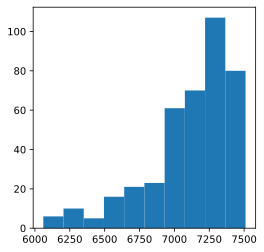

In [273]:
df_v = df.loc[df['Credit Score']>1000]
print('Значение признака Credit Score которые идут выше общепринятой шкалы')
plt.figure(figsize=(4,4))
df_v['Credit Score'].hist()
plt.grid(False);

Значения крединого рейтинга больше 1000 больше похожи на опечатку при заполнение, когда не правилльно указали разделитель знаков.  Произведем замену поделив значение за диапазоном на 10

In [274]:
dict_rep ={}
for k in df['Credit Score']:
    if k >=1000:
        v = k/10
        dict_rep[k]=v
df['Credit Score'].replace(dict_rep, inplace=True)    

### Years of Credit History

Years of Credit History не выходит за невозможные значения. Оставим признак таким каким он есть.

### Признаки после обработки

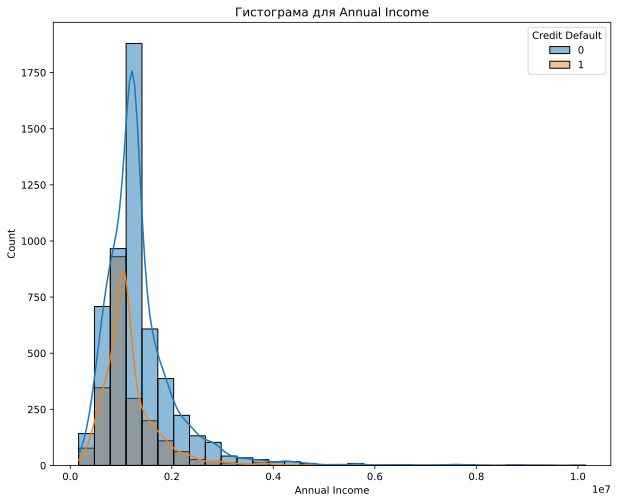

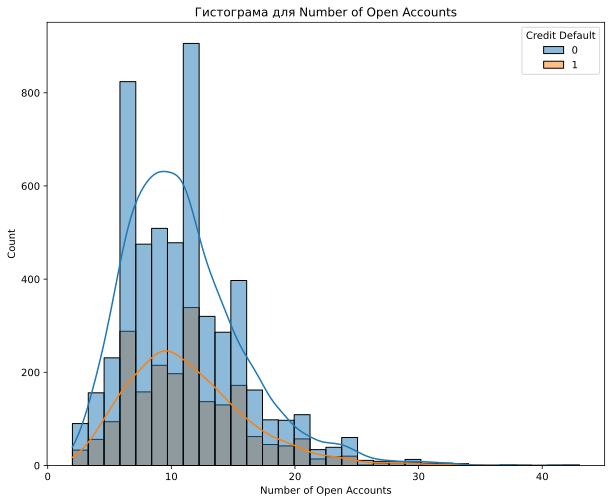

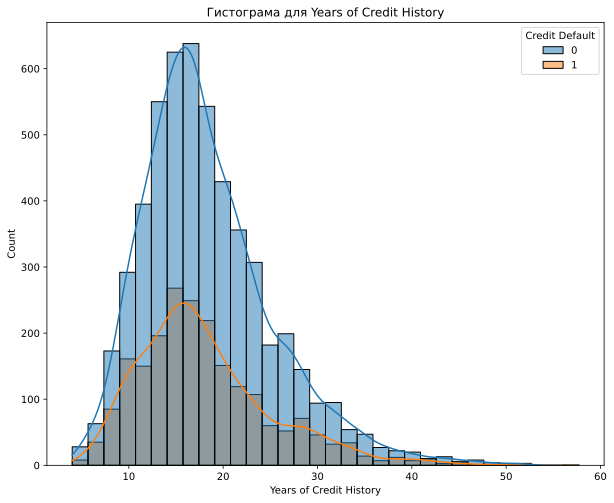

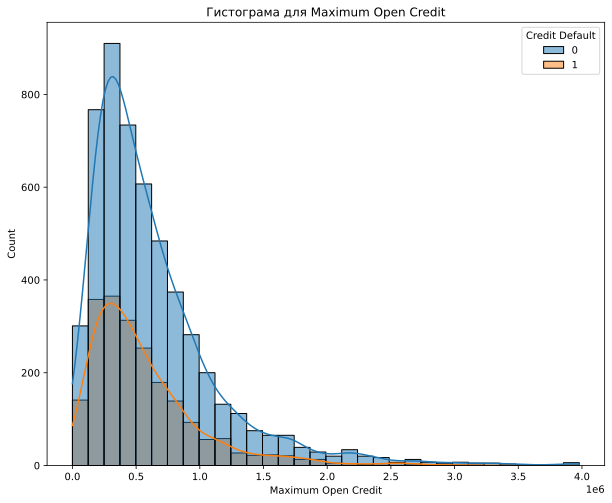

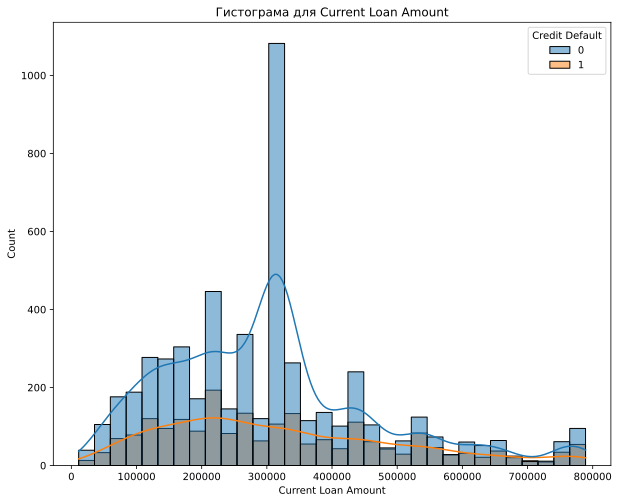

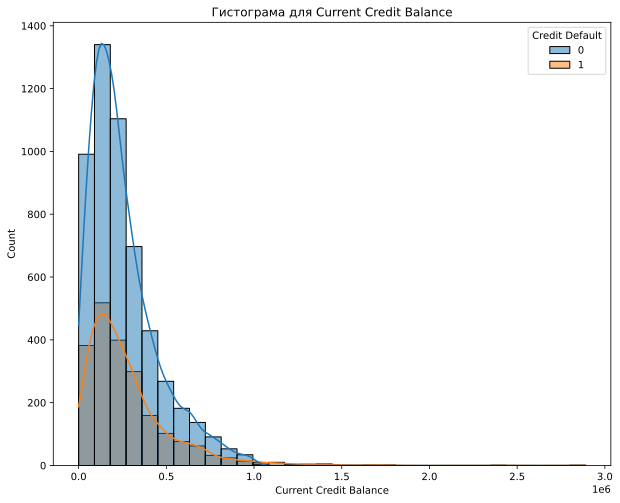

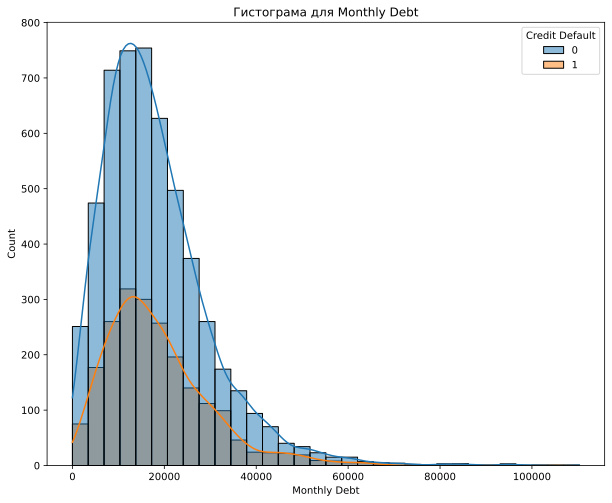

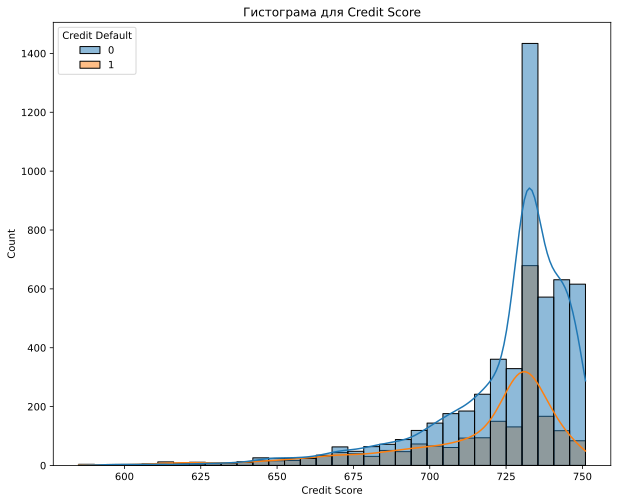

In [275]:
num_hist(df)

### Распределения Категориальных Признаков

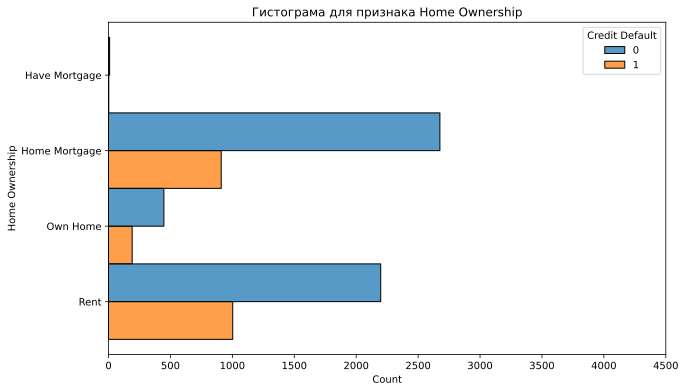

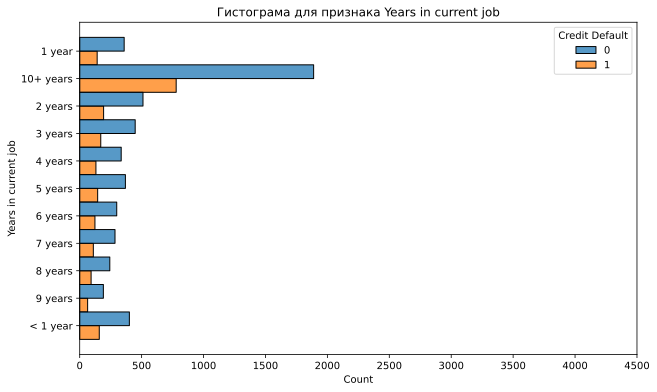

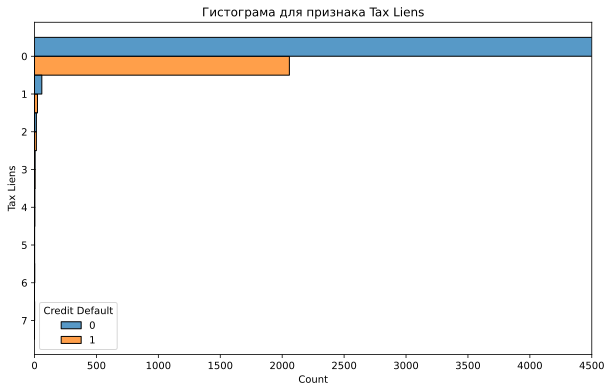

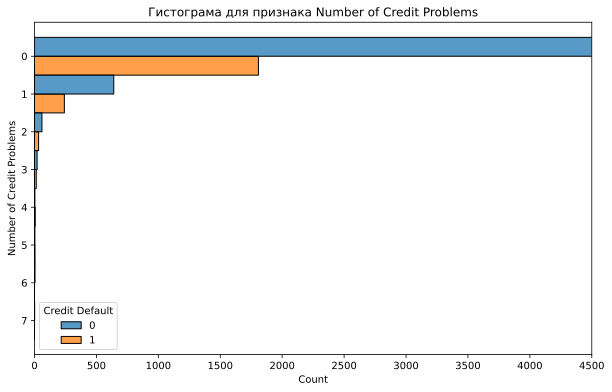

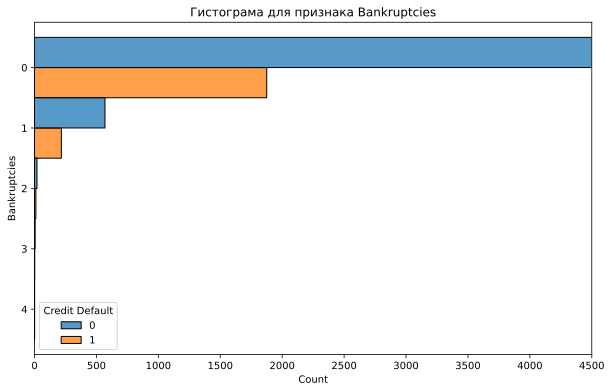

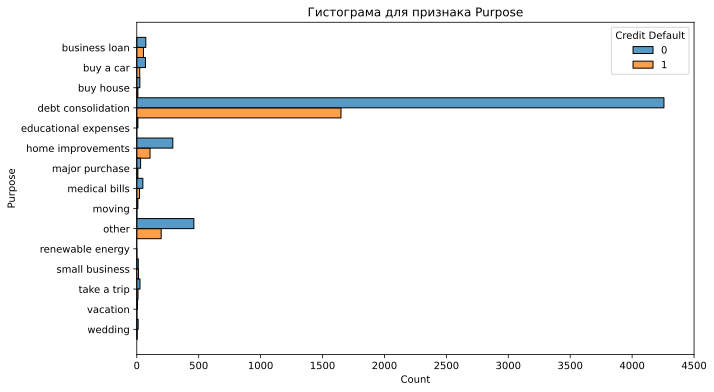

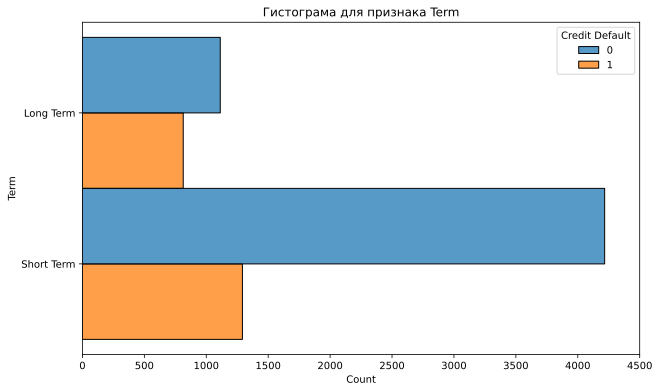

In [276]:
def cat_hist():
    cat = df.select_dtypes(include=['category', 'object'])
    cat['Credit Default'] = df['Credit Default']
    for el in cat.columns[:-1]:
        plt.figure(figsize=(10, 6))
        plt.title('Гистограма для признака ' + str(el))
        plt.xlim (0, 4500)
        sns.histplot(y = cat[el], hue=cat['Credit Default'], multiple="dodge")
    
cat_hist()  

По распределению признаков видим что многие признаки перекрываются друг с другом. 
Модели, которые делят признаки линейно или с использование векторных растояний скорей всего плохо спавятся с разделением данных. Даже добавление ядер в метод опорных векторов врятли улучшит прогнозы поскольку многие признаки что для 1 что для 0 класа имеют одинаковое значение.

### Матрица кореляций

Переведем признак Years in current job в шкалированый и признаки 
 Tax Liens,   Number of Credit Problems, Bankruptcies в числовые 

In [277]:
df_y = df['Years in current job'].str.split(' ', expand=True)
df_y.drop(columns=[1,2], inplace=True)
df_y.replace({'10+':'10','<':'0'}, inplace=True)
df['Years in current job'] = df_y[0]

In [278]:
df['Years in current job'] = df['Years in current job'].astype(np.int8)
df['Tax Liens'] = df['Tax Liens'].astype(np.int8)
df['Number of Credit Problems'] = df['Number of Credit Problems'].astype(np.int8)
df['Bankruptcies'] = df['Bankruptcies'].astype(np.int8)

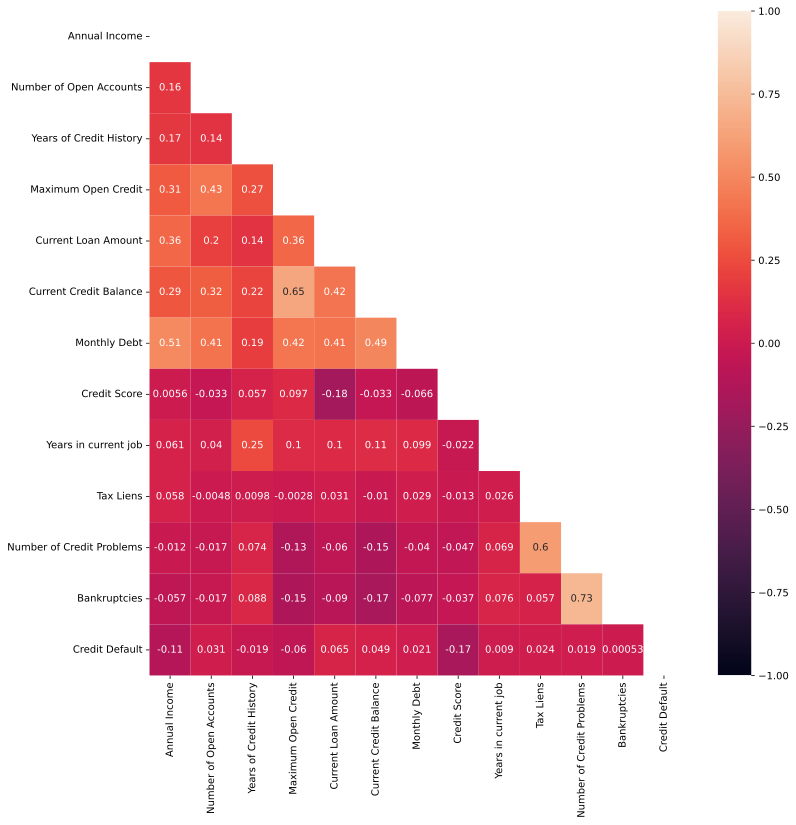

In [279]:
plt.figure(figsize=(12, 12))
mask = np.triu(df.corr())
sns.heatmap(df.corr(), center=0, annot=True, mask = mask, vmax=1, vmin=-1, cmap='rocket');

Наблюдаем высокую кореляцию между признаком 
  * Bankruptcies и Number of Credit Problems
  * Number of Credit Problems и Tax Liens
  * Current Credit Balance и Maximum Open Credit
Наиболее существенаяй кореляция между признаками Bankruptcies и Number of Credit Problems позднее оставим 1 из признаков

### Добавление признака

In [280]:
df['Income Debt Ratio'] = (df['Annual Income']/12)/(df['Monthly Debt']+1)

#### EDA Предобработка данных

In [281]:
def load_data():
    TRAIN = r'course_project_train.csv'
    df = pd.read_csv(TRAIN, sep=',')
    return df
df = load_data()

In [282]:
def train_df_data_prepare(df):
    # замена пропусков
    df = df.drop(columns=['Months since last delinquent'])
    df = nan_replace(df,'Credit Default')
    
    # работа с вбросами
    df = df.loc[(df['Maximum Open Credit'] <= 4e6)]
    
    median_cla_0 = df.loc[df['Credit Default']==0]['Current Loan Amount'].median()
    df.loc[df['Current Loan Amount']>=1e6, 'Current Loan Amount'] = median_cla_0
    
    median_ccb_0 = df.loc[df['Credit Default']==0]['Current Credit Balance'].median()
    median_ccb_1 = df.loc[df['Credit Default']==1]['Current Credit Balance'].median()
    df.loc[(df['Current Credit Balance']>=1e6) & (df['Credit Default']==0), 'Current Credit Balance'] = median_ccb_0
    df.loc[(df['Current Credit Balance']>=1e6) & (df['Credit Default']==0), 'Current Credit Balance'] = median_ccb_1
    
    df_v = df.loc[df['Credit Score']>1000]
    dict_rep ={}
    for k in df['Credit Score']:
        if k >=1000:
            v = k/10
            dict_rep[k]=v
    df['Credit Score'].replace(dict_rep, inplace=True)  
    
    # Преобразование типа данных
    df_y = df['Years in current job'].str.split(' ', expand=True)
    df_y.drop(columns=[1,2], inplace=True)
    df_y.replace({'10+':'10','<':'0'}, inplace=True)
    df['Years in current job'] = df_y[0]
    
    df['Years in current job'] = df['Years in current job'].astype(np.int8)
    df['Tax Liens'] = df['Tax Liens'].astype(np.int8)
    df['Number of Credit Problems'] = df['Number of Credit Problems'].astype(np.int8)
    df['Bankruptcies'] = df['Bankruptcies'].astype(np.int8)
    # Добавление признака
    df['Income Debt Ratio'] = (df['Annual Income']/12)/(df['Monthly Debt']+1)
    
    df = reduce_mem_usage(df)

    return df

df = train_df_data_prepare(df)
df

Класс -  0 Annual Income медиана - 1225747.0
Класс -  0 Bankruptcies медиана - 0.0
Класс -  0 Credit Score медиана - 732.0
Класс -  1 Annual Income медиана - 1055915.5
Класс -  1 Bankruptcies медиана - 0.0
Класс -  1 Credit Score медиана - 730.5
Класс -  0 Years in current job мода - 10+ years
Класс -  1 Years in current job мода - 10+ years
Memory usage of dataframe is 0.82 MB
Memory usage after optimization is: 0.37 MB
Decreased by 55.1%


,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership,Years in current job,Purpose,Term,Credit Default,Income Debt Ratio
0,482087.0,0,11.0,26.299999,685960.0,1,1,313775.0,47386.0,7914.0,749.0,Own Home,10,debt consolidation,Short Term,0,5.075668
2,751412.0,0,11.0,35.000000,1182434.0,0,0,313775.0,308389.0,13651.0,742.0,Home Mortgage,8,debt consolidation,Short Term,0,4.586703
3,805068.0,0,8.0,22.500000,147400.0,1,1,121396.0,95855.0,11338.0,694.0,Own Home,6,debt consolidation,Short Term,0,5.916659
4,776264.0,0,13.0,13.600000,385836.0,1,0,125840.0,93309.0,7180.0,719.0,Rent,8,debt consolidation,Short Term,0,9.008309
6,1511108.0,0,9.0,20.299999,388124.0,0,0,313775.0,51623.0,2317.0,745.0,Home Mortgage,10,home improvements,Short Term,0,54.325138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,1542952.0,0,7.0,12.500000,232364.0,0,0,267982.0,198873.0,15430.0,695.0,Home Mortgage,10,debt consolidation,Long Term,1,8.332534
7489,1394942.0,0,15.0,27.200001,1441396.0,0,0,753764.0,496698.0,16972.0,742.0,Home Mortgage,10,debt consolidation,Short Term,1,6.848828
7490,1368000.0,0,20.0,26.700001,897842.0,0,0,683650.0,517199.0,29868.0,688.0,Own Home,10,debt consolidation,Short Term,1,3.816666
7493,1257610.0,0,14.0,16.500000,821480.0,0,0,448052.0,167428.0,27562.0,676.0,Rent,8,debt consolidation,Long Term,1,3.802229


# Оценка влияния признаков на Целевую переменую

### Кореляция с целевой переменой

In [283]:
dum = pd.get_dummies(df)
sc = StandardScaler()
sc_data = sc.fit_transform(dum)
sc_df = pd.DataFrame(sc_data, columns=dum.columns)

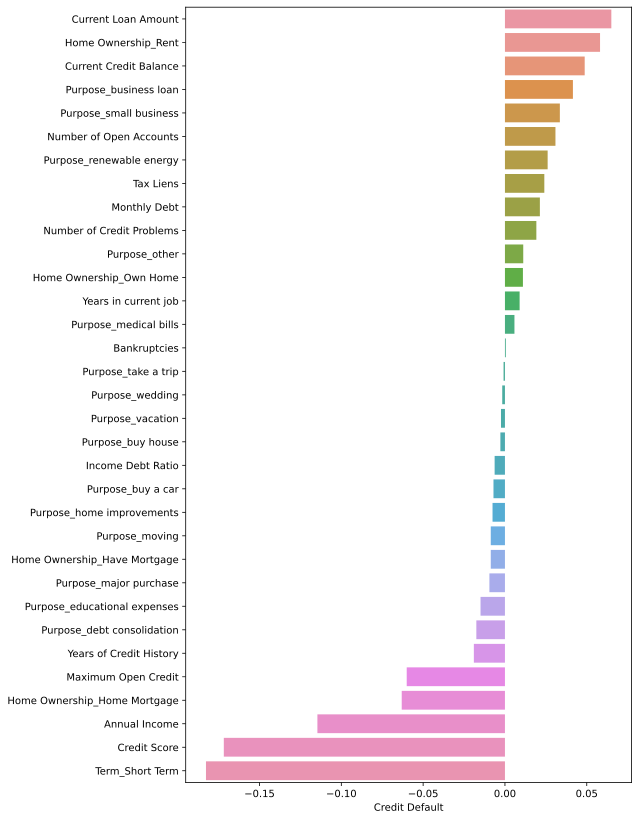

In [284]:
cor_matrix = sc_df.corr()
sorted_corr = cor_matrix['Credit Default'].sort_values(ascending = False)
plt.figure(figsize=(8, 14))
sns.barplot(x=sorted_corr[2:], y=sorted_corr.index[2:]);

Поскольку большая часть признаков не имеет нормального распределения, коряляционый анализ может быть не совсем коректен. Так же корялиционый анализ плохо применим к категориальным признакам. В качестве альтернативы можно воспользоватся корреляцией спирмена, кендала, взаимной информацией и эвристиками заложеными в моделях. Поскольку данные в наборе по большей своей части линейно не сепарабельны в качестве анализа значимости признака будем использовать взаимную информацию и информационный прирост от модели дерево принятия решений.

### Взаимная информация

In [285]:
def get_mi(x, y):
    mi = 0
    cm = contingency_matrix(y, x)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            size = np.sum(cm)
            p_x_y = cm[i][j] / size
            p_x = np.sum(cm[:, j]) / size
            p_y = np.sum(cm[i]) / size

            if p_x_y == 0:
                continue
            mi += p_x_y * np.log(p_x_y / (p_x * p_y))
    return mi

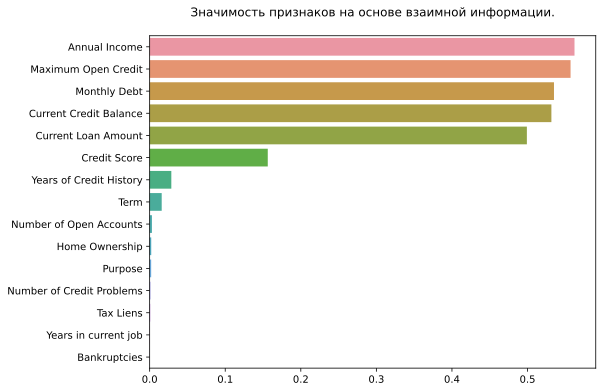

In [286]:
dict_mi = {}
for col in df:
    dict_mi[col]=get_mi(df[col],  df['Credit Default'])
sorted_dict_mi = dict(sorted(dict_mi.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(8, 6))
sns.barplot(x = list(sorted_dict_mi.values())[2:], y = list(sorted_dict_mi.keys())[2:])
plt.title('Значимость признаков на основе взаимной информации.\n');

Наблюдаем максимальный вклад в взаимную информацию у следующих признаков 
* Maximum Open Credit
* Monthly Debt
* Current Credit Balance
* Current Loan Amount
* Credit Score  

После обучения посмотрим какие признаки выбраная модель считает наиболее важными

# Предподготовка к обучению

### Преобразование категориальных данных

In [287]:
df_dump = pd.get_dummies(df)
y = df_dump['Credit Default']
X = df_dump.drop(columns=['Credit Default'])

### Посмотрим возможность добавления признака на основе кластеризации

In [288]:
# функция для визуализации кластеров
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1) # сложим данные 

    figsize = (10, 7)
    if labels is not None: # если lable подали в функцию
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else: # если lable не подали в функцию
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

In [289]:
tsne = TSNE(random_state=17, perplexity=25)
X_tsne = tsne.fit_transform(X);

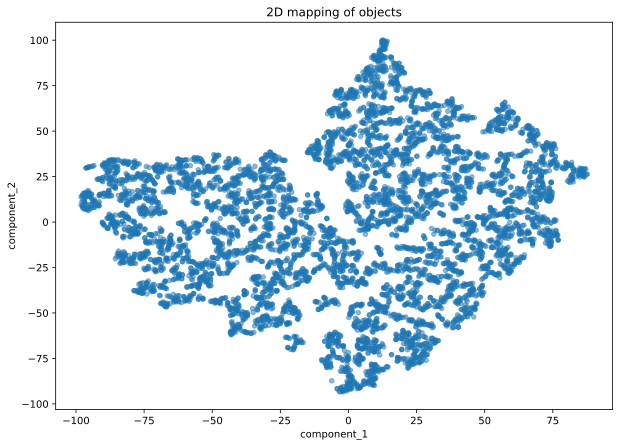

In [290]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_tsne = pd.DataFrame(data=X_tsne, columns=colnames)
components_X_tsne.head()

display_components_in_2D_space(components_X_tsne)

Кластеризация скорей всего не привед к лучшему разделению данные слишком близко друг к другу

In [291]:
def train_test_split_for_balance(df, target):
    """ Функция принимает на вход датафрейм и целевой признак. Производит разбиение на тест и трейн.  
    """
    
    tot_columns = df.columns
    tot_columns = tot_columns.drop(target)

    y = df[target]
    X = df.drop([target], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=21)
    """ если необходимо выполнять стандартизацию данных для векторных и линейных модлий разкоментировать код ниже """
    #scaler = RobustScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    
    
    X_train = pd.DataFrame(X_train, columns=tot_columns)
    X_test = pd.DataFrame(X_test, columns=tot_columns)
    y_train = pd.DataFrame(y_train, columns=[target])
    y_test = pd.DataFrame(y_test, columns=[target])
    
    return X_train, X_test, y_train, y_test

In [292]:
def balance_df_by_target(df, target_name):
    """Функция балансирует данные по целевой переменой """

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1 
    # подсчет дисбаланса между преобладающим и редким класа показывает в сколько раз мажоритарный клас преоблодает над минорным

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])  
        df = df.append(sample, ignore_index=True) # добовляем порцию минорного класа в датафрейм 

    return df.sample(frac=1) 

In [293]:
X_train, X_test, y_train, y_test = train_test_split_for_balance(df_dump, 'Credit Default')

In [294]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
df_balanced['Credit Default'].value_counts()

0    3180
1    2562
Name: Credit Default, dtype: int64

In [295]:
def reports_2(X_train, X_test, y_train, y_test, p_train, p_test ):
                           
    report = classification_report(y_train, p_train)
    a = round(accuracy_score(y_train, p_train)*100, ndigits=4)
    print('Train\n')
    print(f'Accuracy - {a}\nClassification report - \n {report}\n')
    print(f'ROC AUC score - {round(roc_auc_score(y_train, p_train),2)}\n')

    report = classification_report(y_test, p_test)
    a = round(accuracy_score(y_test, p_test)*100, ndigits=4)
    print('Test\n')
    print(f'Accuracy  - {a}\nClassification report - \n {report}\n')
    print(f'ROC AUC score - {round(roc_auc_score(y_test, p_test), 2)}\n')
    y_test = y_test.to_numpy()
    y_test = y_test.flatten()
    print(pd.crosstab(y_test, p_test))

In [296]:
tree = DecisionTreeClassifier(max_depth=12, min_samples_leaf=15, random_state=79)
tree.fit(X_train, y_train)
p_train = tree.predict(X_train)
p_test = tree.predict(X_test)
reports_2(X_train, X_test, y_train, y_test, p_train, p_test)


Train

Accuracy - 83.636
Classification report - 
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      3180
           1       0.79      0.59      0.67      1281

    accuracy                           0.84      4461
   macro avg       0.82      0.76      0.78      4461
weighted avg       0.83      0.84      0.83      4461


ROC AUC score - 0.76

Test

Accuracy  - 76.6387
Classification report - 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      2150
           1       0.60      0.47      0.53       825

    accuracy                           0.77      2975
   macro avg       0.71      0.68      0.69      2975
weighted avg       0.75      0.77      0.76      2975


ROC AUC score - 0.68

col_0     0    1
row_0           
0      1889  261
1       434  391


In [297]:
CATB = catb.CatBoostClassifier(silent=True, random_state=99, n_estimators = 15, max_depth=9, min_data_in_leaf=20)
CATB.fit(X_train, y_train)
p_train = CATB.predict(X_train)
p_test = CATB.predict(X_test)
reports_2(X_train, X_test, y_train, y_test, p_train, p_test)

Train

Accuracy - 89.6212
Classification report - 
               precision    recall  f1-score   support

           0       0.89      0.98      0.93      3180
           1       0.93      0.69      0.79      1281

    accuracy                           0.90      4461
   macro avg       0.91      0.83      0.86      4461
weighted avg       0.90      0.90      0.89      4461


ROC AUC score - 0.83

Test

Accuracy  - 77.7815
Classification report - 
               precision    recall  f1-score   support

           0       0.81      0.90      0.85      2150
           1       0.64      0.45      0.53       825

    accuracy                           0.78      2975
   macro avg       0.73      0.68      0.69      2975
weighted avg       0.76      0.78      0.76      2975


ROC AUC score - 0.68

col_0     0    1
row_0           
0      1941  209
1       452  373


In [298]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

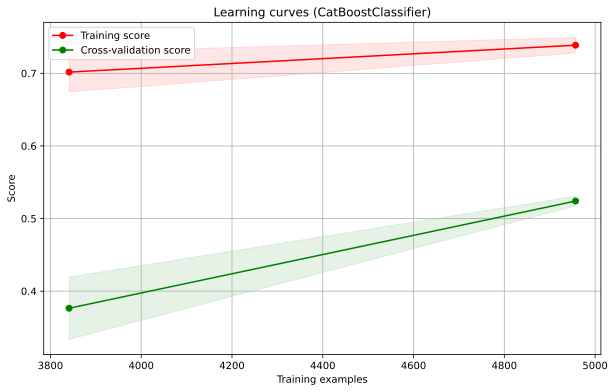

In [299]:
show_learning_curve_plot(CATB, X, y)

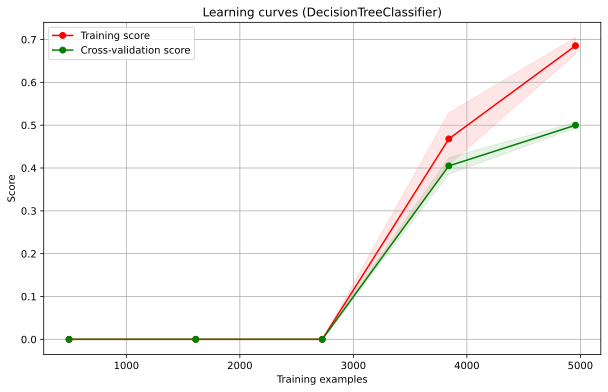

In [300]:
show_learning_curve_plot(tree, X, y)

Как видим из графиков модель с бустингом все таки имеет небольшое приемущество над деревом решений. Метрика чуть лучше. Однако дерево принятия решений требует мееньше вычислительной мощности и проще в инторпретации выберем в качестве основной модели более простую модель.

In [301]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (7, len(feature_importances) * 0.3))
    
    sns.barplot(feature_importances['importance'][:get_top], feature_importances['feature'][:get_top])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

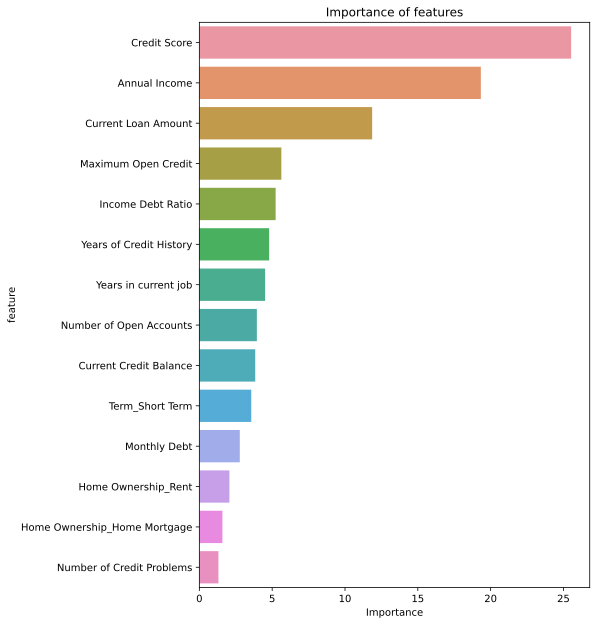

In [302]:
important_features_top = show_feature_importances(X_train.columns, CATB.feature_importances_, get_top=14)

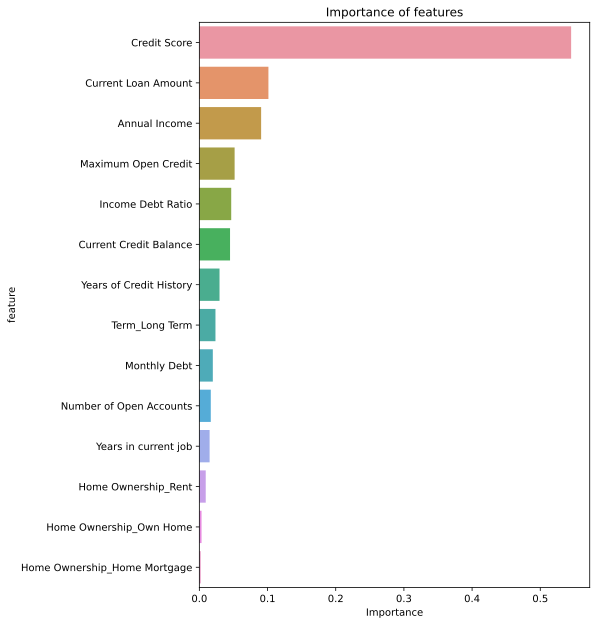

In [303]:
important_features_top = show_feature_importances(X_train.columns, tree.feature_importances_, get_top=14)

### Обучение при сокращении количества признаков 
Выберем 14 самых влиятельных признаков по дереву решений и обучемся на них
Среди данных признаков уже исключена пара Bankruptcies и Number of Credit Problems  с кореляцией более 0ю7

In [304]:
important_features_top.append('Credit Default')
df_reduced = df_dump[important_features_top]
df_reduced

,Credit Score,Current Loan Amount,Annual Income,Maximum Open Credit,Income Debt Ratio,Current Credit Balance,Years of Credit History,Term_Long Term,Monthly Debt,Number of Open Accounts,Years in current job,Home Ownership_Rent,Home Ownership_Own Home,Home Ownership_Home Mortgage,Credit Default
0,749.0,313775.0,482087.0,685960.0,5.075668,47386.0,26.299999,0,7914.0,11.0,10,0,1,0,0
2,742.0,313775.0,751412.0,1182434.0,4.586703,308389.0,35.000000,0,13651.0,11.0,8,0,0,1,0
3,694.0,121396.0,805068.0,147400.0,5.916659,95855.0,22.500000,0,11338.0,8.0,6,0,1,0,0
4,719.0,125840.0,776264.0,385836.0,9.008309,93309.0,13.600000,0,7180.0,13.0,8,1,0,0,0
6,745.0,313775.0,1511108.0,388124.0,54.325138,51623.0,20.299999,0,2317.0,9.0,10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,695.0,267982.0,1542952.0,232364.0,8.332534,198873.0,12.500000,1,15430.0,7.0,10,0,0,1,1
7489,742.0,753764.0,1394942.0,1441396.0,6.848828,496698.0,27.200001,0,16972.0,15.0,10,0,0,1,1
7490,688.0,683650.0,1368000.0,897842.0,3.816666,517199.0,26.700001,0,29868.0,20.0,10,0,1,0,1
7493,676.0,448052.0,1257610.0,821480.0,3.802229,167428.0,16.500000,1,27562.0,14.0,8,1,0,0,1


In [305]:
X_train, X_test, y_train, y_test = train_test_split_for_balance(df_reduced, 'Credit Default')

In [306]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
df_balanced['Credit Default'].value_counts()

0    3180
1    2562
Name: Credit Default, dtype: int64

In [307]:
tree = DecisionTreeClassifier(max_depth=12, min_samples_leaf=15, random_state=79)
tree.fit(X_train, y_train)
p_train = tree.predict(X_train)
p_test = tree.predict(X_test)
reports_2(X_train, X_test, y_train, y_test, p_train, p_test)

Train

Accuracy - 83.636
Classification report - 
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      3180
           1       0.79      0.59      0.67      1281

    accuracy                           0.84      4461
   macro avg       0.82      0.76      0.78      4461
weighted avg       0.83      0.84      0.83      4461


ROC AUC score - 0.76

Test

Accuracy  - 76.5714
Classification report - 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      2150
           1       0.60      0.47      0.53       825

    accuracy                           0.77      2975
   macro avg       0.71      0.68      0.69      2975
weighted avg       0.75      0.77      0.76      2975


ROC AUC score - 0.68

col_0     0    1
row_0           
0      1887  263
1       434  391


### Выводы

* В результате работы была осуществлена замена пропусков внутри класа медианой либо модой
* Произведена замена явных вбросов на основе характеристики признаков
* Отоброно 14 наиболее влиятельных признаков на основе эвристики модели Дерева принятия решений
* В качестве базовой модели использовали дерево принятия решений поскольку оно хорошо справляется с линейно несепарабельными данными, в качестве более сложной модели использовали CATBost. Хотя CATBost несколько лучше справляется с задачей, разница между моделями не большая.
* Целевая метрика f1 для 1 класа - 0.53
* Добавленый новый признак  Incomу Debth Ratio стал - 5 по вкладу в алгоритме дерева принятий решений.
* Лучшей метрики f1 при заданом наборе признаков врятли удастся добится. Метод K means так же показал что кластеризация данных врятли улучшит разрешение задачи. В системе нехватает ряда признаков из кредитной истории плательщиков. Таких как - наличие просрочек по крелитам, наличие досрочного погошения кредита, сферы работы и должности плательщика

### Предсказание на контрольном покете данных

In [308]:
def load_test():
    test_path = r'course_project_test.csv'
    test = pd.read_csv(test_path)
    return test

test = load_test()

In [309]:
def nan_replace_test(test):
    num = test.select_dtypes(exclude=['category', 'object'])
    cat = test.select_dtypes(include=['category', 'object'])

    for col in num:
        test[col].fillna(num[col].median(), inplace=True)
    
    for col in cat:
        test[col].fillna(cat[col].mode()[0], inplace=True)  
    return test

In [310]:
def test_prepare(test):
    
    test_y = test['Years in current job'].str.split(' ', expand=True)
    test_y.drop(columns=[1,2], inplace=True)
    test_y.replace({'10+':'10','<':'0'}, inplace=True)
    test['Years in current job'] = test_y[0]
 
    test = nan_replace_test(test)
    
    test['Years in current job'] = test['Years in current job'].astype(int)
    
    test['Income Debt Ratio'] = (test['Annual Income']/12)/(test['Monthly Debt']+1)
  
    return test
    

In [311]:
test = test_prepare(test)
test_dump = pd.get_dummies(test)
important_features_top2 = important_features_top[:-1][:]
test_reduced = test_dump[important_features_top2]

In [312]:
test_reduced 

,Credit Score,Current Loan Amount,Annual Income,Maximum Open Credit,Income Debt Ratio,Current Credit Balance,Years of Credit History,Term_Long Term,Monthly Debt,Number of Open Accounts,Years in current job,Home Ownership_Rent,Home Ownership_Own Home,Home Ownership_Home Mortgage
0,731.0,162470.0,1178475.0,220968.0,14.412423,105906.0,12.5,0,6813.0,9.0,4,1,0,0
1,699.0,78298.0,231838.0,55946.0,8.331105,46037.0,32.7,0,2318.0,6.0,1,1,0,0
2,7260.0,200178.0,1152540.0,204600.0,5.127870,146490.0,13.7,0,18729.0,10.0,3,0,0,1
3,739.0,217382.0,1220313.0,456302.0,3.689868,213199.0,17.0,0,27559.0,16.0,10,0,0,1
4,706.0,777634.0,2340952.0,1207272.0,4.578682,425391.0,23.6,1,42605.0,11.0,6,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,745.0,99999999.0,1020053.0,559152.0,5.649260,162735.0,29.1,0,15046.0,14.0,10,0,0,1
2496,731.0,468512.0,1178475.0,1737780.0,2.976218,1439269.0,17.0,0,32996.0,15.0,2,0,0,1
2497,695.0,430496.0,1171806.0,1706430.0,2.645423,676438.0,12.8,0,36912.0,48.0,2,0,0,1
2498,744.0,257774.0,723520.0,945780.0,4.463858,391248.0,28.8,0,13506.0,14.0,10,1,0,0


In [313]:
preict = tree.predict(test_reduced)
answer = test
answer['Credit Default'] = preict

In [314]:
PREPARED_DATASET_PATH = 'answer.csv'
answer.to_csv(PREPARED_DATASET_PATH, index=True)